In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import RGBTemporalDataModule

trans = {
	'RandomRotate90': {
		'p': 0.5
	},
	'HorizontalFlip': {
		'p': 0.5
	},
	'VerticalFlip': {
		'p': 0.5
	},
}
# dm = RGBTemporalDataModule(val_size=0.2, batch_size=1, train_trans=trans)
# months = ["September", "October"]
dm = RGBTemporalDataModule(val_size=0.2, batch_size=1)
dm.setup()

train: 6952
val: 1737
test: 2773


In [3]:
dl = dm.train_dataloader()
images, labels = next(iter(dl))

images.shape, images.dtype, images.max(), images.min(), labels.shape

(torch.Size([1, 12, 3, 256, 256]),
 torch.float32,
 tensor(1.),
 tensor(0.),
 torch.Size([1, 256, 256]))

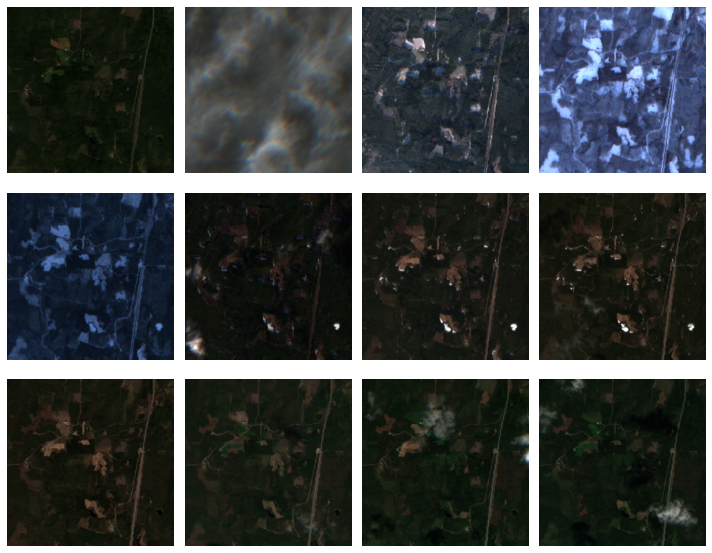

In [4]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3, 4, figsize=(10,8))
# dl = dm.train_dataloader(shuffle=False)
dl = dm.train_dataloader()
images, labels = next(iter(dl))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(images[0][i*4+j].permute(1, 2, 0))
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

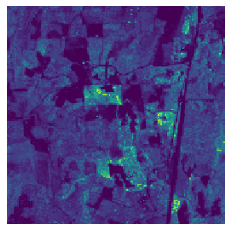

In [5]:
plt.imshow(labels[0])
plt.axis('off')
plt.show()

In [6]:
from src.module import RGBTemporalModule

hparams = {
	'backbone': 'resnet18',
	'pretrained': False,
	'num_latents': 256, # N
	'latent_dim': 256, # D
	'num_blocks': 3,  # L
    'n_heads': 4,
	'num_months': 12#len(months)
}

module = RGBTemporalModule(hparams)
# module.backbone

outputs = module(images)

outputs.shape

torch.Size([1, 256, 256])

In [13]:
import pytorch_lightning as pl

dm = RGBTemporalDataModule(batch_size=1, months=["September"])

hparams = {
	'backbone': 'resnet18',
	'pretrained': False,
	'num_latents': 256, # N
	'latent_dim': 256, # D
	'num_blocks': 1, # L
	'n_heads': 1,
	'num_months': 1,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-2
	},
}

module = RGBTemporalModule(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=200,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type             | Params
----------------------------------------------
0 | backbone | ResNet           | 11.2 M
1 | encoder  | PerceiverEncoder | 1.8 M 
----------------------------------------------
13.0 M    Trainable params
0         Non-trainable params
13.0 M    Total params
25.909    Total estimated model params size (MB)


train: 8689
test: 2773


Training: 0it [00:00, ?it/s]

In [112]:
dl = dm.train_dataloader(shuffle=False)
images, labels = next(iter(dl))
preds = module.predict(images)

preds.shape, preds.dtype, preds.min(), preds.max()

(torch.Size([1, 256, 256]), torch.float32, tensor(0.), tensor(8.7282e-09))

IndexError: index 1 is out of bounds for dimension 0 with size 1

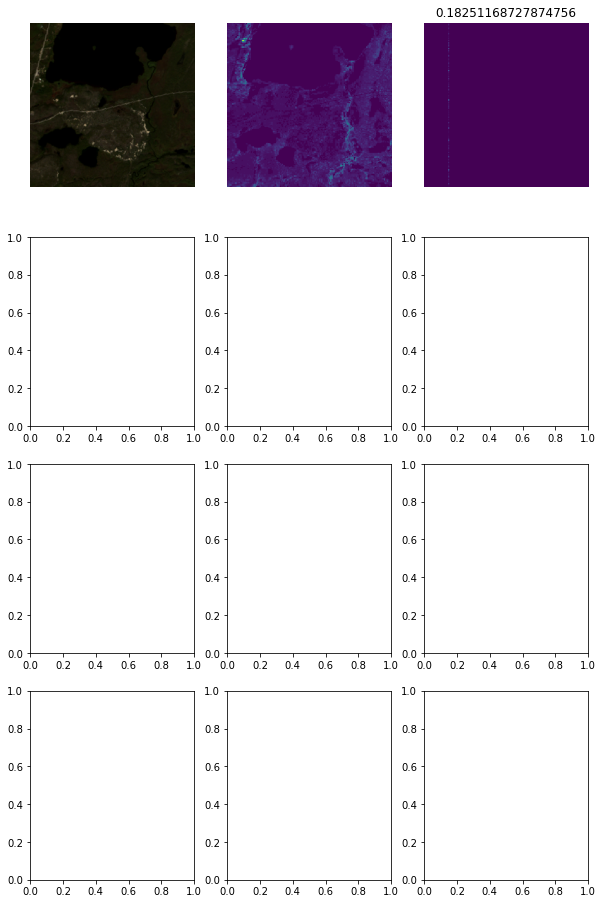

In [114]:
import torch 

fig, ax = plt.subplots(4, 3, figsize=(10, 16))
for i in range(4):
	ax[i, 0].imshow(images[i][0].permute(1, 2, 0))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(labels[i])
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
	ax[i, 2].set_title(torch.sqrt(
            torch.sum((preds[i] - labels[i])**2)).item())
plt.tight_layout()
plt.show()

In [31]:
import pandas as pd 

train = pd.read_csv('data/test.csv')
train

,Unnamed: 0,filename,chip_id,satellite,month,corresponding_agbm
0,522,00a28320_S1_00.tif,00a28320,S1,September,00a28320_agbm.tif
1,523,00a28320_S1_01.tif,00a28320,S1,October,00a28320_agbm.tif
2,524,00a28320_S1_02.tif,00a28320,S1,November,00a28320_agbm.tif
3,525,00a28320_S1_03.tif,00a28320,S1,December,00a28320_agbm.tif
4,526,00a28320_S1_04.tif,00a28320,S1,January,00a28320_agbm.tif
...,...,...,...,...,...,...
63343,252421,fff812c0_S2_07.tif,fff812c0,S2,April,fff812c0_agbm.tif
63344,252422,fff812c0_S2_08.tif,fff812c0,S2,May,fff812c0_agbm.tif
63345,252423,fff812c0_S2_09.tif,fff812c0,S2,June,fff812c0_agbm.tif
63346,252424,fff812c0_S2_10.tif,fff812c0,S2,July,fff812c0_agbm.tif


In [8]:
train = train[train.satellite == 'S2']

In [9]:
grouped = train.groupby('chip_id').agg(list)[['filename', 'month', 'corresponding_agbm']]
grouped

,filename,month,corresponding_agbm
chip_id,,,
0003d2eb,"[0003d2eb_S2_00.tif, 0003d2eb_S2_01.tif, 0003d...","[September, October, February, March, April, M...","[0003d2eb_agbm.tif, 0003d2eb_agbm.tif, 0003d2e..."
000aa810,"[000aa810_S2_06.tif, 000aa810_S2_07.tif, 000aa...","[March, April, May, June, July, August]","[000aa810_agbm.tif, 000aa810_agbm.tif, 000aa81..."
000d7e33,"[000d7e33_S2_06.tif, 000d7e33_S2_07.tif, 000d7...","[March, April, May, June, July, August]","[000d7e33_agbm.tif, 000d7e33_agbm.tif, 000d7e3..."
00184691,"[00184691_S2_06.tif, 00184691_S2_07.tif, 00184...","[March, April, May, June, July, August]","[00184691_agbm.tif, 00184691_agbm.tif, 0018469..."
001b0634,"[001b0634_S2_00.tif, 001b0634_S2_01.tif, 001b0...","[September, October, November, January, Februa...","[001b0634_agbm.tif, 001b0634_agbm.tif, 001b063..."
...,...,...,...
ffc563f4,"[ffc563f4_S2_00.tif, ffc563f4_S2_01.tif, ffc56...","[September, October, November, January, Februa...","[ffc563f4_agbm.tif, ffc563f4_agbm.tif, ffc563f..."
ffc730b9,"[ffc730b9_S2_00.tif, ffc730b9_S2_01.tif, ffc73...","[September, October, November, January, Februa...","[ffc730b9_agbm.tif, ffc730b9_agbm.tif, ffc730b..."
ffc7d4f2,"[ffc7d4f2_S2_00.tif, ffc7d4f2_S2_01.tif, ffc7d...","[September, October, November, January, Februa...","[ffc7d4f2_agbm.tif, ffc7d4f2_agbm.tif, ffc7d4f..."


In [10]:
labels = []
for chip_id, chip in grouped.iterrows():
	assert len(set(chip.corresponding_agbm)) == 1
	labels.append(chip['corresponding_agbm'][0])
grouped['corresponding_agbm'] = labels
grouped

,filename,month,corresponding_agbm
chip_id,,,
0003d2eb,"[0003d2eb_S2_00.tif, 0003d2eb_S2_01.tif, 0003d...","[September, October, February, March, April, M...",0003d2eb_agbm.tif
000aa810,"[000aa810_S2_06.tif, 000aa810_S2_07.tif, 000aa...","[March, April, May, June, July, August]",000aa810_agbm.tif
000d7e33,"[000d7e33_S2_06.tif, 000d7e33_S2_07.tif, 000d7...","[March, April, May, June, July, August]",000d7e33_agbm.tif
00184691,"[00184691_S2_06.tif, 00184691_S2_07.tif, 00184...","[March, April, May, June, July, August]",00184691_agbm.tif
001b0634,"[001b0634_S2_00.tif, 001b0634_S2_01.tif, 001b0...","[September, October, November, January, Februa...",001b0634_agbm.tif
...,...,...,...
ffc563f4,"[ffc563f4_S2_00.tif, ffc563f4_S2_01.tif, ffc56...","[September, October, November, January, Februa...",ffc563f4_agbm.tif
ffc730b9,"[ffc730b9_S2_00.tif, ffc730b9_S2_01.tif, ffc73...","[September, October, November, January, Februa...",ffc730b9_agbm.tif
ffc7d4f2,"[ffc7d4f2_S2_00.tif, ffc7d4f2_S2_01.tif, ffc7d...","[September, October, November, January, Februa...",ffc7d4f2_agbm.tif


In [11]:
max_len, max_len_chip_id = 0, None
for chip_id, group in grouped.iterrows():
	if len(group.month) > max_len:
		max_len = len(group.month)
		max_len_chip_id = chip_id

max_len, max_len_chip_id

(12, '0060c0a5')

In [12]:
months = grouped.month.loc[max_len_chip_id]
months

['September',
 'October',
 'November',
 'December',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August']

In [14]:
filenames = []
for chip_id, group in grouped.iterrows():
	filenames.append([None]*len(months))
	for i,m in enumerate(months):
		if m in group.month:
			filenames[-1][i] = group.filename[group.month.index(m)]

grouped2 = pd.DataFrame({'filename': filenames, 'corresponding_agbm': labels[1]}, index=grouped.index)
grouped2

,filename,corresponding_agbm
chip_id,,
0003d2eb,"[0003d2eb_S2_00.tif, 0003d2eb_S2_01.tif, None,...",000aa810_agbm.tif
000aa810,"[None, None, None, None, None, None, 000aa810_...",000aa810_agbm.tif
000d7e33,"[None, None, None, None, None, None, 000d7e33_...",000aa810_agbm.tif
00184691,"[None, None, None, None, None, None, 00184691_...",000aa810_agbm.tif
001b0634,"[001b0634_S2_00.tif, 001b0634_S2_01.tif, 001b0...",000aa810_agbm.tif
...,...,...
ffc563f4,"[ffc563f4_S2_00.tif, ffc563f4_S2_01.tif, ffc56...",000aa810_agbm.tif
ffc730b9,"[ffc730b9_S2_00.tif, ffc730b9_S2_01.tif, ffc73...",000aa810_agbm.tif
ffc7d4f2,"[ffc7d4f2_S2_00.tif, ffc7d4f2_S2_01.tif, ffc7d...",000aa810_agbm.tif


In [16]:
grouped2.index.values

array(['0003d2eb', '000aa810', '000d7e33', ..., 'ffc7d4f2', 'ffd8db7a',
       'fff05995'], dtype=object)